In [1]:
%load_ext autoreload
%autoreload 2

from nb_002 import *

In [2]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10_dog_air'

train_ds = FilesDataset(PATH/'train')
valid_ds = FilesDataset(PATH/'test', train_ds.classes)

x = train_ds[1][0]

## CIFAR augmentation

In [3]:
@reg_transform
def pad(x, padding, mode='reflect') -> TfmType.Start:
    return F.pad(x[None], (padding,)*4, mode=mode)[0]

@reg_transform
def crop(x, size, row_pct:uniform, col_pct:uniform) -> TfmType.Pixel:
    size = listify(size,2)
    rows,cols = size
    row = int((x.size(1)-rows)*row_pct)
    col = int((x.size(2)-cols)*col_pct)
    return x[:, row:row+rows, col:col+cols]

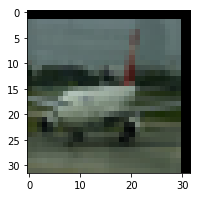

In [4]:
show_image(crop(pad(x, 4, 'constant'), 32, 0.25, 0.75), hide_axis=False)

In [5]:
tfms = [flip_lr_tfm(p=0.5),
        pad_tfm(padding=4, mode='constant'),
        crop_tfm(size=32, row_pct=(0,1.), col_pct=(0,1.))]

In [6]:
#export
@dataclass
class TfmDataset(Dataset):
    ds: Dataset
    tfms: Collection[Callable] = None
        
    def __len__(self): return len(self.ds)
    
    def __getitem__(self,idx):
        x,y = self.ds[idx]
        if self.tfms is not None: x = apply_tfms(self.tfms)(x)
        return x,y

In [7]:
train_tds = TfmDataset(train_ds, tfms)

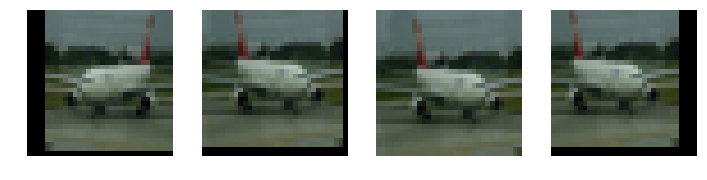

In [11]:
_,axes = plt.subplots(1,4, figsize=(12,9))
for ax in axes.flat: show_image(train_tds[1][0], ax)

## Simplify transforms

In [16]:
x,_ = next(iter(data.train_dl))
x.shape

torch.Size([64, 3, 32, 32])

In [17]:
#export
def get_batch_stats(dl):
    x,_ = next(iter(dl))
    # hack for multi-axis reduction until pytorch has it natively
    x = x.transpose(0,1).contiguous().view(x.size(1),-1).cpu()
    return x.mean(1).reshape(3,1,1), x.std(1).reshape(3,1,1)

In [18]:
data_mean,data_std = get_batch_stats(data.train_dl)

In [19]:
#export
def normalize(mean,std,x): return (x-mean) / std
def denormalize(mean,std,x): return x*std + mean

In [20]:
cifar_transform = partial(normalize, data_mean, data_std)

In [21]:
data2 = DataBunch(train_ds, valid_ds, bs=bs, train_tfm=cifar_transform, valid_tfm=cifar_transform)
len(data2.train_dl), len(data2.valid_dl)

(157, 16)

In [22]:
x,y = next(iter(data2.train_dl))
x = x.cpu()

In [23]:
x = denormalize(data_mean, data_std, x).clamp(0,1.)

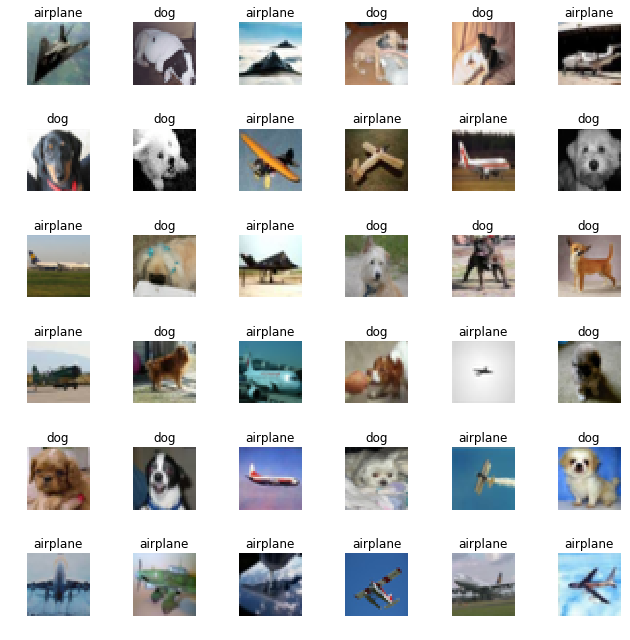

In [24]:
show_images(x,y,6,train_ds.classes)

In [25]:
learn = Learner(data2, simple_cnn([3,16,16,2], [3,3,3], [2,2,2]))

In [26]:
# learn.fit(2, 0.2)

## CIFAR training

In [17]:
data_mean = torch.tensor([0.49, 0.48, 0.45])
data_std = torch.tensor([0.25, 0.24, 0.26])

In [19]:
bs=64

In [20]:
data = DataBunch(train_tds, valid_ds, bs=bs, train_tfms=batch_transforms, valid_tfms=batch_transforms)
len(data.train_dl), len(data.valid_dl)

(157, 16)

In [21]:
x_,y_ = next(iter(data.train_dl))
x_ = denormalize(data_mean, data_std, x_).clamp(0,1.)

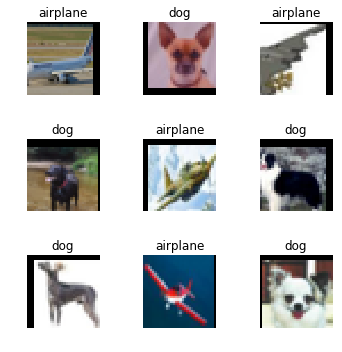

In [22]:
show_images(x_,y_,3,train_ds.classes, figsize=(5,5))

In [27]:
learn = Learner(data, simple_cnn([3,16,16,2], [3,3,3], [2,2,2]))

In [28]:
opt_fn = partial(optim.SGD, momentum=0.9)

In [30]:
learn.fit(2, 0.1, opt_fn)

0 0.2471585681438446


1 0.22548777282238006

